# Data Parameters
Input

- Frames: 5 in 1 out
- Target: 8 stations
- Channels: AirNow, Wind U/V
- Temporal data (Months, Weekdays, Days, Hours), with cyclical features

Model
- See "Architecture"

Result


In [1]:
# file locations
# for libs.plotting
import sys
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz")
# for the model checkpoint callback (if enabled)
model_checkpoint_file = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/basic_experiments/model.keras'
# where the training data is stored
data_path = "/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

#from libs.sequence import PWWBPyDataset

In [3]:
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy", "MAIAC_AOD_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "TROPOMI_NO2_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy", "MAIAC_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "TROPOMI_NO2_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy", "MAIAC_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "TROPOMI_NO2_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{data_path + file}" for file in X_train_files]
Y_training_files_paths = f"{data_path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [5]:
X_train_2 = np.load(f"{data_path + "Temporal_Encoding_X_train.npy"}")
X_test_2 = np.load(f"{data_path + "Temporal_Encoding_X_test.npy"}")
X_valid_2 = np.load(f"{data_path + "Temporal_Encoding_X_valid.npy"}")

import numpy as np
import pandas as pd
print("Original temporal encoding shape:", X_train_2.shape)
# Generate timestamps for the entire dataset
timestamps = pd.date_range(start=START_DATE, end=END_DATE, freq='h')
# Calculate where each dataset starts
n_train = len(X_train_2)
n_valid = len(X_valid_2)
n_test = len(X_test_2)

def create_cyclical_only_encoding(X_temporal, start_idx, timestamps, frames_per_sample=5):
    """
    Create a new temporal encoding with ONLY cyclical features.
    This replaces one-hot encoding with efficient sin/cos encoding.
    """
    n_samples = X_temporal.shape[0]
    
    # 8 features: 4 temporal dimensions × 2 (sin & cos)
    n_features = 8
    
    X_temporal_new = np.zeros((n_samples, frames_per_sample, n_features))
    
    for i in range(n_samples):
        sample_timestamps = timestamps[start_idx + i : start_idx + i + frames_per_sample]
        
        # Hour encoding (24-hour cycle) - Daily patterns
        hours = sample_timestamps.hour
        X_temporal_new[i, :, 0] = np.sin(2 * np.pi * hours / 24)
        X_temporal_new[i, :, 1] = np.cos(2 * np.pi * hours / 24)
        
        # Day of week encoding (7-day cycle) - Weekly patterns
        day_of_week = sample_timestamps.dayofweek  # 0=Monday, 6=Sunday
        X_temporal_new[i, :, 2] = np.sin(2 * np.pi * day_of_week / 7)
        X_temporal_new[i, :, 3] = np.cos(2 * np.pi * day_of_week / 7)
        
        # Day of month encoding - Monthly patterns
        # Note: We use (day-1) to map 1-31 to 0-30 for proper cyclical encoding
        days = sample_timestamps.day
        days_in_month = sample_timestamps.days_in_month  # Handles 28/29/30/31 day months
        X_temporal_new[i, :, 4] = np.sin(2 * np.pi * (days - 1) / days_in_month)
        X_temporal_new[i, :, 5] = np.cos(2 * np.pi * (days - 1) / days_in_month)
        
        # Month encoding (12-month cycle) - Seasonal patterns
        months = sample_timestamps.month
        X_temporal_new[i, :, 6] = np.sin(2 * np.pi * months / 12)
        X_temporal_new[i, :, 7] = np.cos(2 * np.pi * months / 12)
    
    return X_temporal_new

# Replace the old encoding with clean cyclical encoding
X_train_2 = create_cyclical_only_encoding(X_train_2, 0, timestamps, frames_per_sample)
X_valid_2 = create_cyclical_only_encoding(X_valid_2, n_train, timestamps, frames_per_sample)
X_test_2 = create_cyclical_only_encoding(X_test_2, n_train + n_valid, timestamps, frames_per_sample)

print("\nNew temporal encoding shapes (cyclical only):")
print(f"X_train_2: {X_train_2.shape}")
print(f"X_valid_2: {X_valid_2.shape}")
print(f"X_test_2: {X_test_2.shape}")

# Feature reference
print("\nFeature mapping:")
print("Feature 0: hour_sin")
print("Feature 1: hour_cos")
print("Feature 2: day_of_week_sin")
print("Feature 3: day_of_week_cos")
print("Feature 4: day_of_month_sin")
print("Feature 5: day_of_month_cos")
print("Feature 6: month_sin")
print("Feature 7: month_cos")

# Verify with a sample
print("\nSample verification (first timestamp):")
first_timestamp = timestamps[0]
print(f"Timestamp: {first_timestamp}")
print(f"Hour: {first_timestamp.hour} -> sin: {X_train_2[0, 0, 0]:.4f}, cos: {X_train_2[0, 0, 1]:.4f}")
print(f"Day of week: {first_timestamp.dayofweek} -> sin: {X_train_2[0, 0, 2]:.4f}, cos: {X_train_2[0, 0, 3]:.4f}")
print(f"Day of month: {first_timestamp.day}/{first_timestamp.days_in_month} -> sin: {X_train_2[0, 0, 4]:.4f}, cos: {X_train_2[0, 0, 5]:.4f}")
print(f"Month: {first_timestamp.month} -> sin: {X_train_2[0, 0, 6]:.4f}, cos: {X_train_2[0, 0, 7]:.4f}")

Original temporal encoding shape: (12274, 5, 74)

New temporal encoding shapes (cyclical only):
X_train_2: (12274, 5, 8)
X_valid_2: (2630, 5, 8)
X_test_2: (2631, 5, 8)

Feature mapping:
Feature 0: hour_sin
Feature 1: hour_cos
Feature 2: day_of_week_sin
Feature 3: day_of_week_cos
Feature 4: day_of_month_sin
Feature 5: day_of_month_cos
Feature 6: month_sin
Feature 7: month_cos

Sample verification (first timestamp):
Timestamp: 2022-12-01 00:00:00
Hour: 0 -> sin: 0.0000, cos: 1.0000
Day of week: 3 -> sin: 0.4339, cos: -0.9010
Day of month: 1/31 -> sin: 0.0000, cos: 1.0000
Month: 12 -> sin: -0.0000, cos: 1.0000


In [6]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4, Compton = 5
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 
    'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Crestline - Lake Gregory', 
    'Temecula (Lake Skinner)', 'Fontana - Arrow Highway', 'EBAM-2'
]
sensor = {location : i for i, location in enumerate(sensors)}
sensor_names = sensors[:8]

Y_train = Y_train[:, :1, :8].copy()
Y_test = Y_test[:, :1, :8].copy()
Y_valid = Y_valid[:, :1, :8].copy()

# Model Definition

## Architecture

In [7]:
output_frames, output_stations = Y_train.shape[1:]
input_shape_1 = X_train.shape[1:] # (frames, height, width, channels)
input_shape_2 = X_train_2.shape[1:] # (frames, encoded time)

print(
    "Frame data input\n"
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape_1}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

print(
    "Temporal data input\n"
    f"X_train shape: {X_train_2.shape}\n"
    
    f"X_test shape:  {X_test_2.shape}\n"

    f"X_valid shape: {X_valid_2.shape}\n"

    f"Input shape:   {input_shape_2}\n"
)

Frame data input
X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 1, 8)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 1, 8)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 1, 8)

Input shape:   (5, 40, 40, 3)
Output shape:  (1, 8)

Temporal data input
X_train shape: (12274, 5, 8)
X_test shape:  (2631, 5, 8)
X_valid shape: (2630, 5, 8)
Input shape:   (5, 8)



In [8]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Flatten 
from keras.layers import Input

tf.keras.backend.set_image_data_format('channels_last')

spatiotemporal_input = Input(shape=input_shape_1)
temporal_encoding_input = Input(shape=input_shape_2)
temporal_block = Flatten()(temporal_encoding_input)

x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding='same', return_sequences=True)(spatiotemporal_input)
x = ConvLSTM2D(filters=30, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
x = Conv3D(filters=15, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
conv_block = Flatten()(x)

x = Concatenate()([conv_block, temporal_block])
x = Dense(units=output_stations * output_frames, activation='relu')(x)
next_frame_pred = Reshape((output_frames, output_stations))(x)

model = Model(
    inputs=[spatiotemporal_input, temporal_encoding_input],
    outputs=next_frame_pred
)
model.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004)
)
model.summary()

2025-08-02 17:26:06.325241: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 17:26:06.333730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754180766.344785   44886 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754180766.348829   44886 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-02 17:26:06.359611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 40, 40, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 40, 40, │      9,780 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 5, 40, 40, │     48,720 │ conv_lstm2d[0][0] │
│ (ConvLSTM2D)        │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 40, 40, │     12,165 │ conv_lstm2d_1[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 40, 40, │        406 │ conv3d[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8000)      │          0 │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 40)        │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8040)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │     64,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 8)      │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 135,399 (528.90 KB)

 Trainable params: 135,399 (528.90 KB)

 Non-trainable params: 0 (0.00 B)

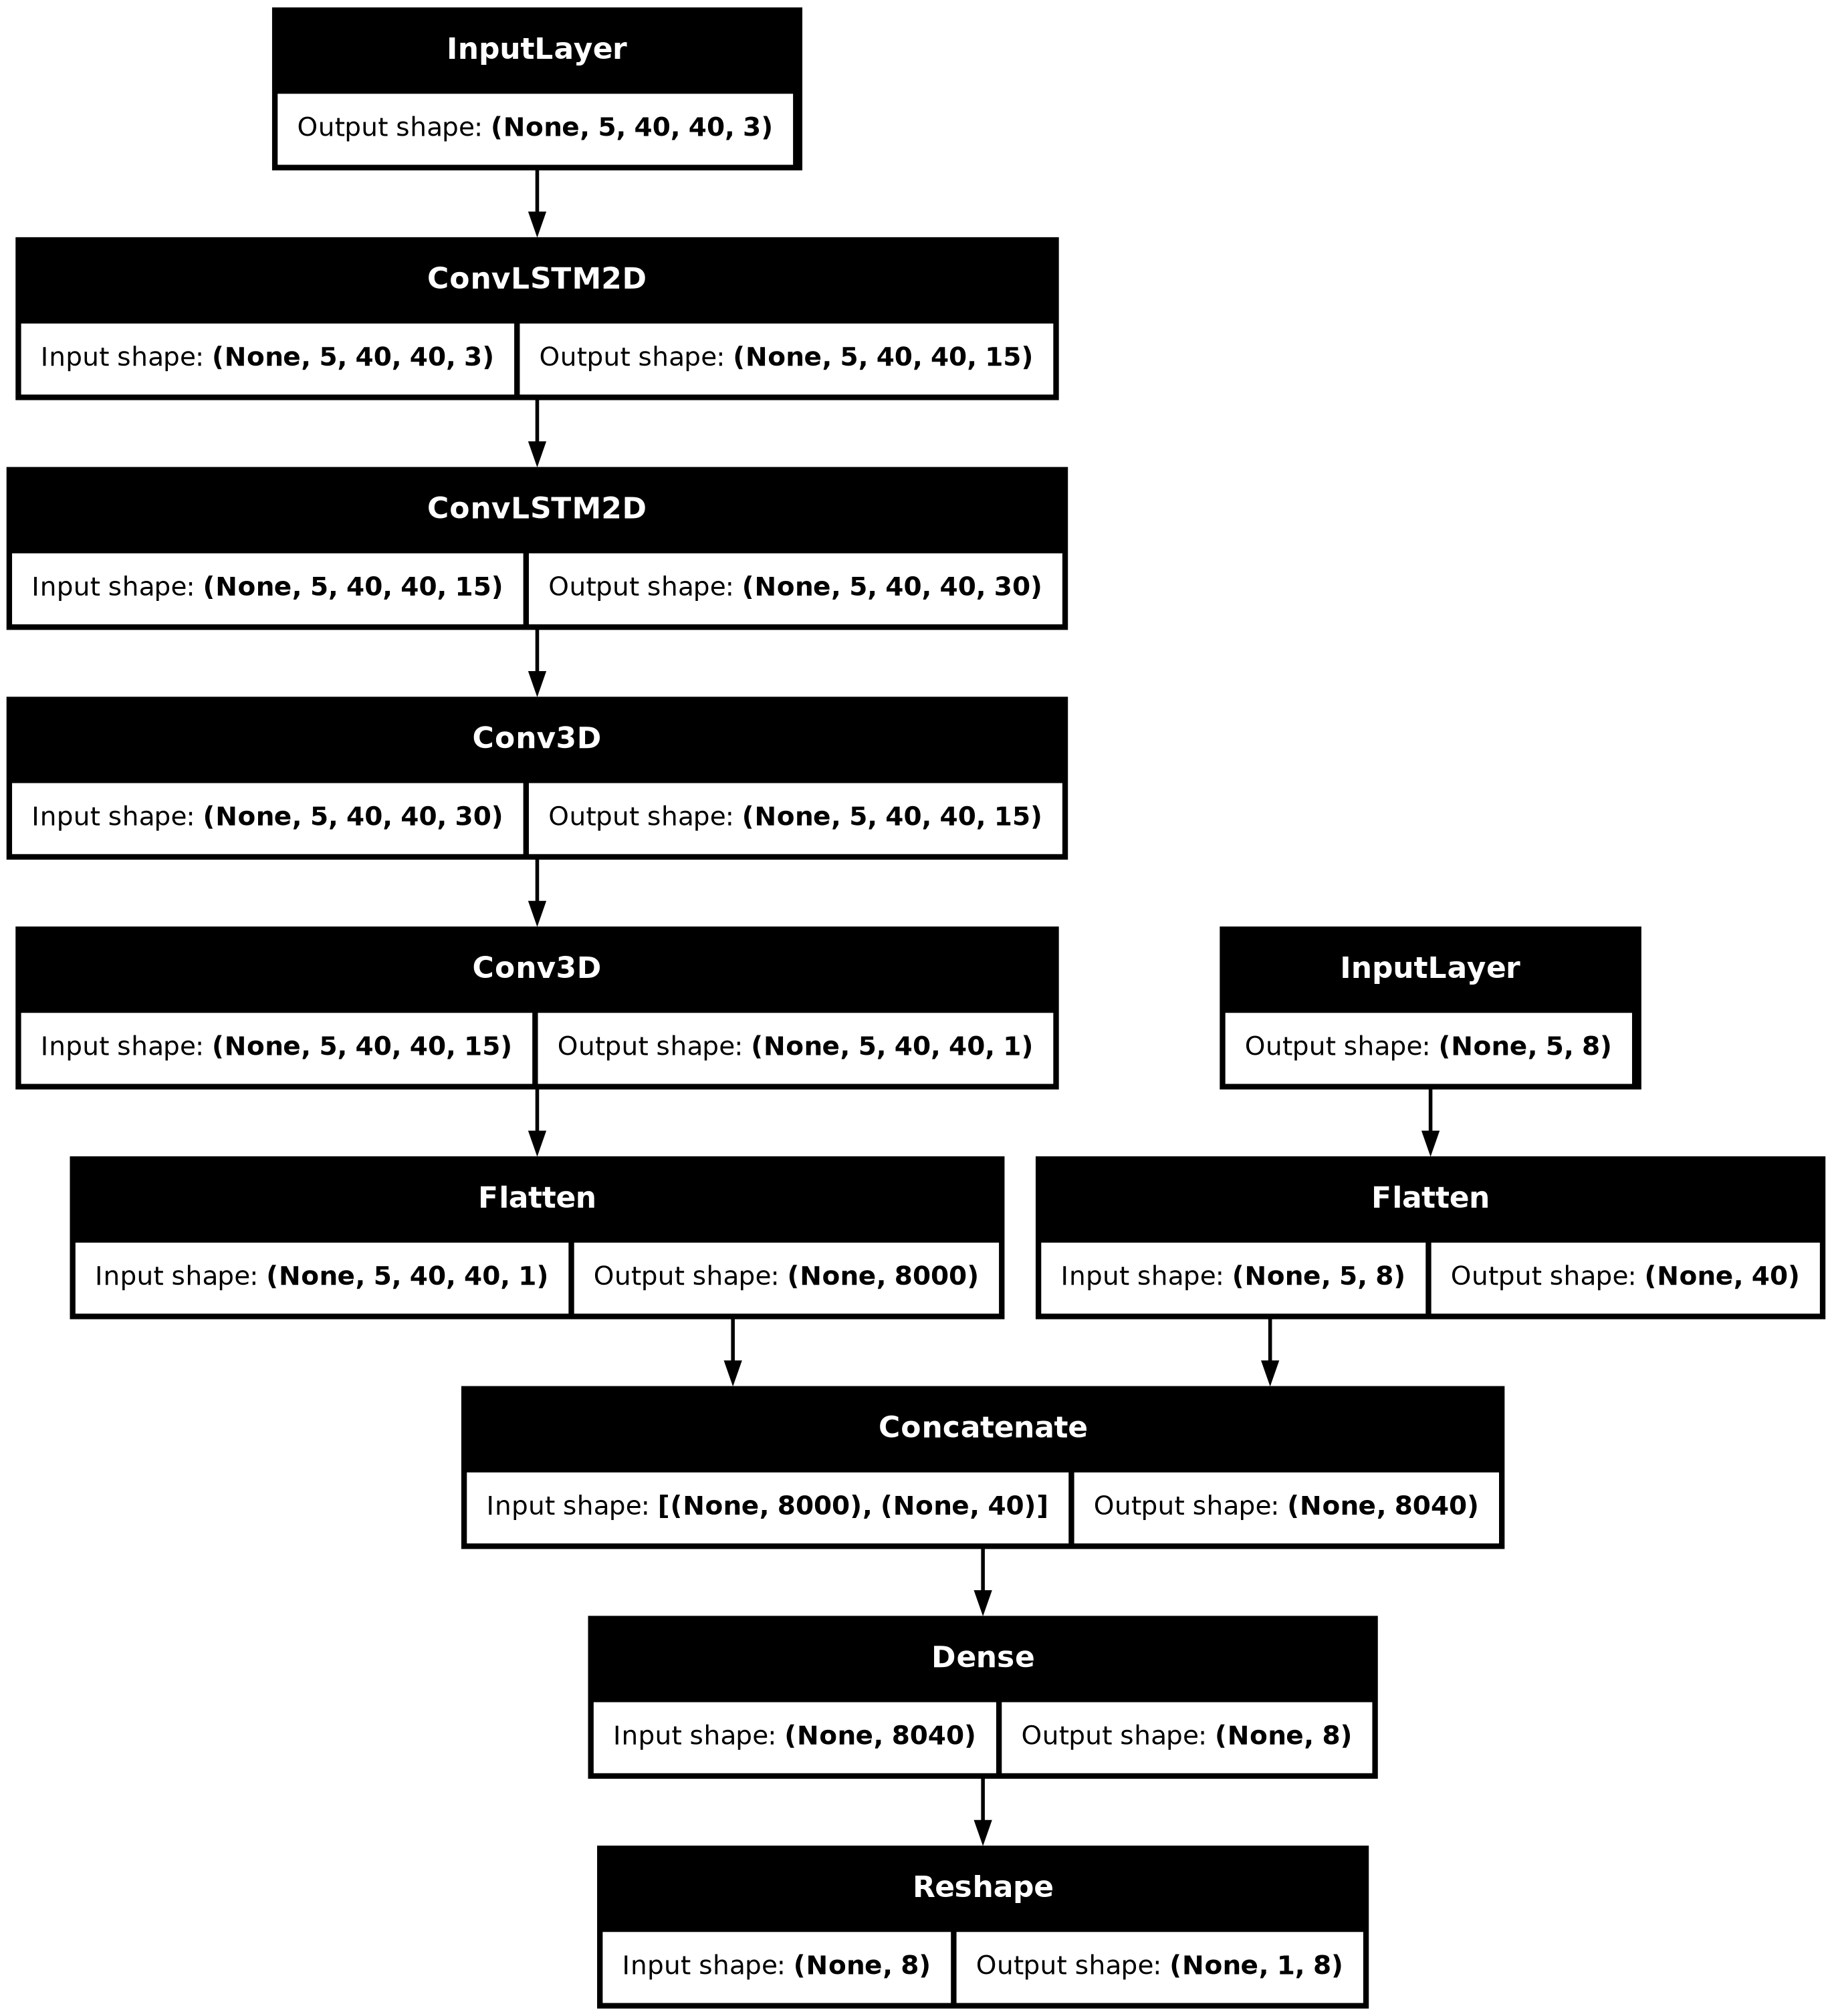

In [9]:
keras.utils.plot_model(model, "model_graph.png", show_shapes=True)

## Callbacks

In [10]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    #early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [11]:
history = model.fit(
    x=[X_train, X_train_2],
    y=Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_valid, X_valid_2], Y_valid),
    callbacks=callbacks
)

Epoch 1/100


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1754180773.190175   44993 service.cc:148] XLA service 0x7fd7b40f03c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754180773.190201   44993 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-08-02 17:26:13.278727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754180773.603468   44993 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-08-02 17:26:14.287838: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2

  3/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 8.8883

I0000 00:00:1754180776.781535   44993 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5.5079

2025-08-02 17:26:39.790476: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-02 17:26:39.940831: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 5.5038

2025-08-02 17:26:44.706087: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-02 17:26:44.761663: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - loss: 5.4997 - val_loss: 2.8670
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.6480 - val_loss: 2.3509
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.3098 - val_loss: 2.1706
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.1730 - val_loss: 2.1828
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 2.0253 - val_loss: 2.0162
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 1.8515 - val_loss: 1.9854
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 1.7515 - val_loss: 1.8957
Epoch 8/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 1.6478 - val_loss: 1.7703
Epoch 9/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 1.5736 - val_loss: 1.6708
Epoch 10/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 1.5176 - val_loss: 1.5861
Epoch 11/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - loss: 1.4647 - val_loss: 1.4946
Epoch 12/100
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-08-02 18:06:59.871813: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-02 18:06:59.925019: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

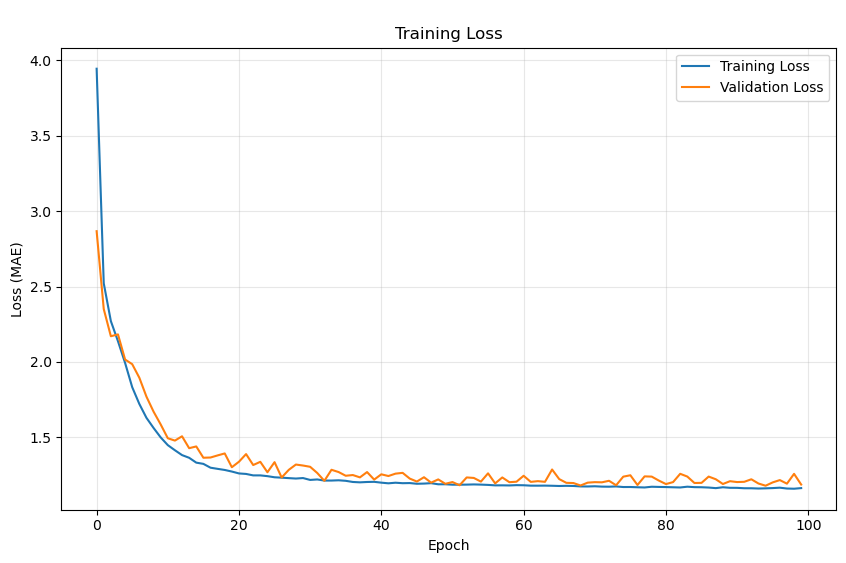

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = model.predict([X_test, X_test_2], verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
print(Y_test.shape, y_pred.shape)

(2631, 1, 8) (2631, 1, 8)


In [14]:
from libs.plotting import *
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as mape

# avg error of each station across all frames
results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        mape(np.squeeze(Y_test[:-1]), np.squeeze(Y_test[1:]))*100,
        mape(np.squeeze(Y_test), np.squeeze(y_pred))*100,
        mape(np.squeeze(Y_test[:-1]), np.squeeze(y_pred[1:]))*100,
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.030924,1.925130,1.068804
NRMSE,18.326171,17.376307,9.644420
MAE,1.373517,1.293143,0.723396
MAPE,18.439053,17.990251,10.799349
R2,0.887086,0.898574,0.968728


In [15]:
# avg pm2.5 over the entire area vs avg prediction over entire area
# basically all stations merged into 1 value instead of average error on each particular station
# difference with above: calculate errors of each station, THEN average VS calculate average PM2.5, THEN calculate error
y_pred_avg = np.mean(y_pred, axis=-1)
Y_test_avg = np.mean(Y_test, axis=-1)

results = [
    [
        rmse(Y_test_avg[1:], Y_test_avg[:-1]), 
        rmse(y_pred_avg, Y_test_avg),
        rmse(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        nrmse(Y_test_avg[1:], Y_test_avg[:-1]),
        nrmse(y_pred_avg, Y_test_avg),        
        nrmse(y_pred_avg[1:], Y_test_avg[:-1]),

    ],
    [        
        mae(Y_test_avg[1:], Y_test_avg[:-1]),
        mae(y_pred_avg, Y_test_avg),
        mae(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        mape(np.squeeze(Y_test_avg[:-1]), np.squeeze(Y_test_avg[1:]))*100,
        mape(np.squeeze(Y_test_avg), np.squeeze(y_pred_avg))*100,
        mape(np.squeeze(Y_test_avg[:-1]), np.squeeze(y_pred_avg[1:]))*100,
    ],
    [
        r2_score(Y_test_avg[:-1], Y_test_avg[1:]),
        r2_score(Y_test_avg, y_pred_avg),
        r2_score(Y_test_avg[:-1], y_pred_avg[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.030916,0.861899,0.603008
NRMSE,9.302540,7.779536,5.441281
MAE,0.767576,0.637075,0.448838
MAPE,7.460947,6.166331,4.522633
R2,0.935881,0.955231,0.978063


In [16]:
'''
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(Y_test[1:, 0]))*100,
        mape(np.squeeze(Y_test[:, 0]), np.squeeze(y_pred[:, 0]))*100,
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(y_pred[1:, 0]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)
''';

In [17]:
# first frame LA error
results = [
    [
        rmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]), 
        rmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        rmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        nrmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        nrmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),        
        nrmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),

    ],
    [        
        mae(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        mae(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        mae(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(Y_test[1:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:, 0, 4]), np.squeeze(y_pred[:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(y_pred[1:, 0, 4]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0, 4], Y_test[1:, 0, 4]),
        r2_score(Y_test[:, 0, 4], y_pred[:, 0, 4]),
        r2_score(Y_test[:-1, 0, 4], y_pred[1:, 0, 4]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.024425,1.902080,1.076551
NRMSE,14.480573,13.608990,7.700494
MAE,1.420499,1.330718,0.723443
MAPE,10.915003,10.152682,5.829016
R2,0.898886,0.910781,0.971406


In [18]:
# first frame, error breakdown for every sensor, nrmse
results = [
    *[
        [
            nrmse(Y_test[1:, 0, i], Y_test[:-1, 0, i]),
            nrmse(y_pred[:, 0, i], Y_test[:, 0, i]),
            nrmse(y_pred[1:, 0, i], Y_test[:-1, 0, i])
        ]
        for i in range(len(sensor_names))
    ]
]
df = pd.DataFrame(
    results, 
    columns=['Baseline NRMSE', 'Model NRMSE', 'Model NRMSE Shifted'], 
    index=sensor_names
)
display(df)

,Baseline NRMSE,Model NRMSE,Model NRMSE Shifted
Simi Valley - Cochran Street,19.049932,19.209614,9.461889
Reseda,20.034834,21.469765,13.828411
Santa Clarita,15.806760,15.205373,6.956494
North Holywood,15.910362,14.238276,7.959857
Los Angeles - N. Main Street,14.480573,13.608990,7.700494
Compton,21.827155,20.117699,12.080133
Long Beach Signal Hill,22.377316,21.079775,10.490110
Anaheim,16.540607,15.038963,7.811764


In [19]:
'''
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)
''';

# Plots

## Snapshot plots - first frame

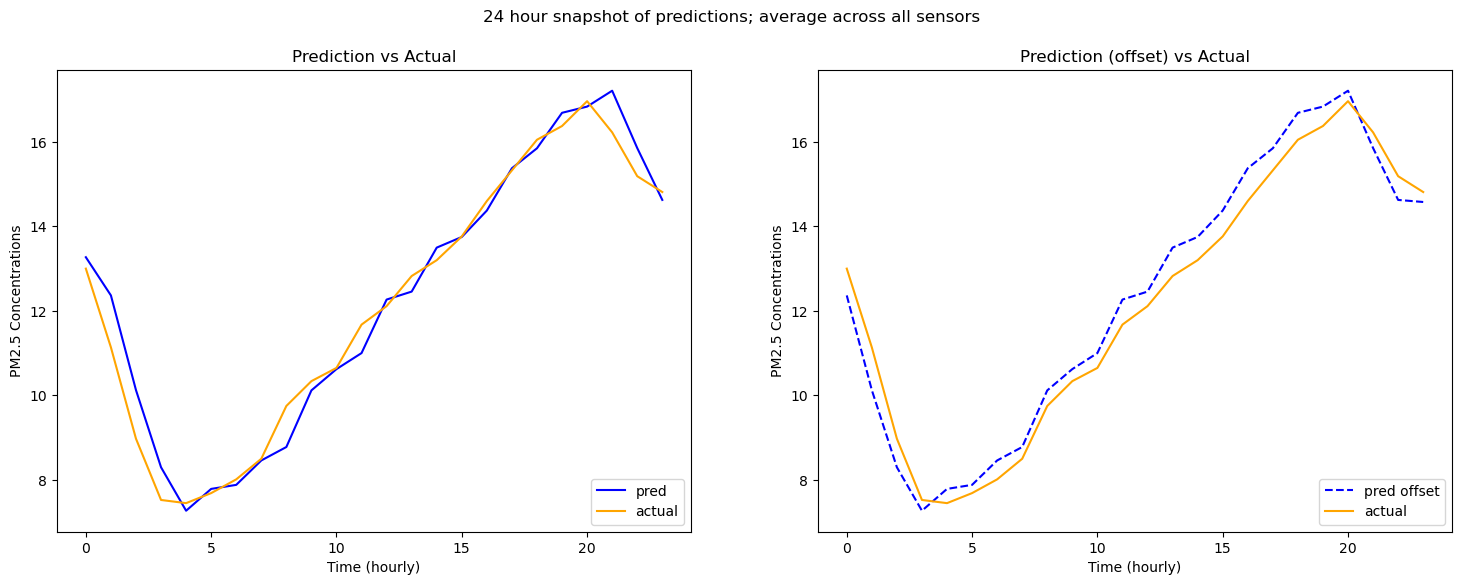

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions; average across all sensors")

axes[0].plot(y_pred_avg[1000:1024, 0], color='blue', label='pred')
axes[0].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred_avg[1001:1025, 0], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

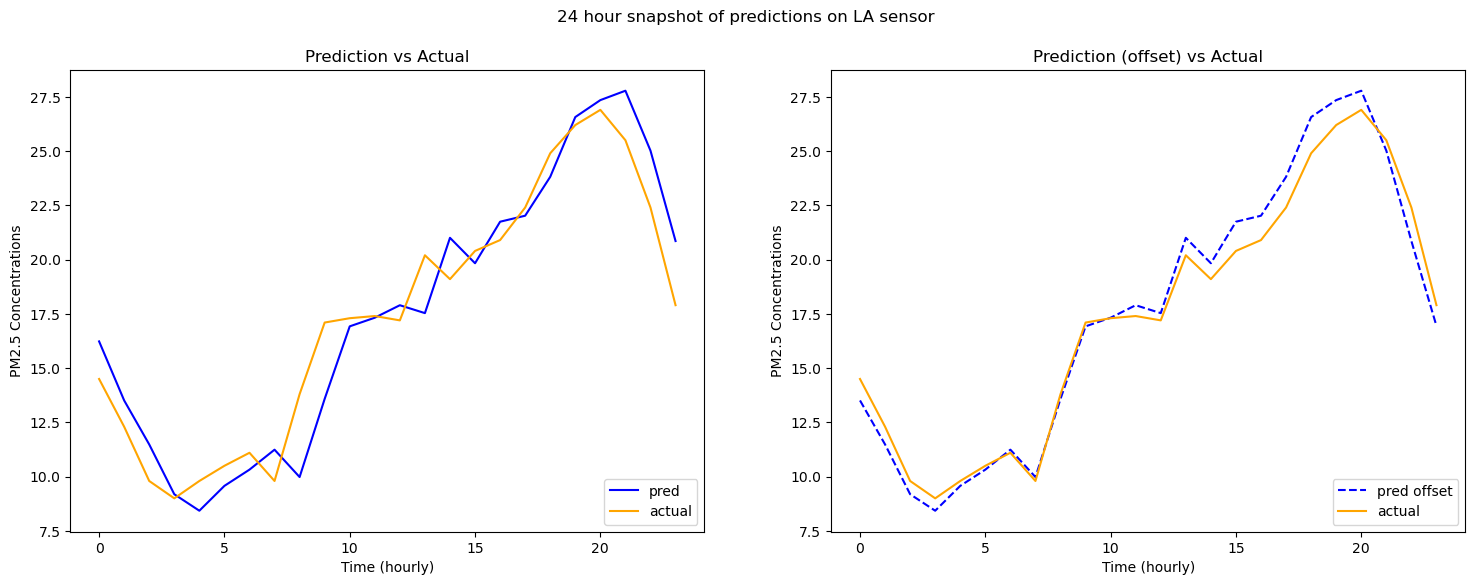

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions on LA sensor")

axes[0].plot(y_pred[1000:1024, 0, 4], color='blue', label='pred')
axes[0].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred[1001:1025, 0, 4], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

[]

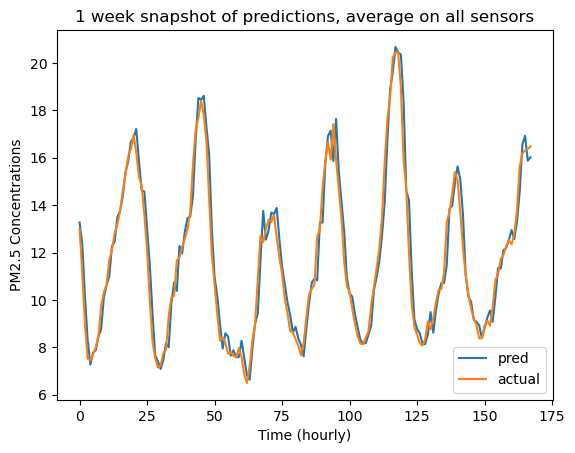

In [22]:
plt.plot(y_pred_avg[1000:1168, 0], label='pred')
plt.plot(Y_test_avg[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, average on all sensors")
plt.legend(loc="lower right")
plt.plot()

[]

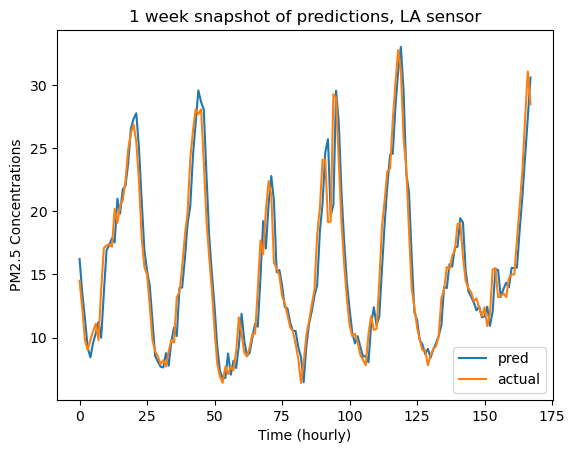

In [23]:
plt.plot(y_pred[1000:1168, 0, 4], label='pred')
plt.plot(Y_test[1000:1168, 0, 4], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, LA sensor")
plt.legend(loc="lower right")
plt.plot()

In [24]:
# best/worst if all stations are averaged into one
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

for i in range(len(y_pred) - 168):
    err = nrmse(y_pred_avg[i:i+168, 0], Y_test_avg[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i
print(best_idx, worst_idx)

1389 2176


In [25]:
dates = pd.date_range(START_DATE, END_DATE, freq='h')
y_test_start_idx = len(Y_valid)
y_test_end_idx = len(Y_valid) + len(Y_test)
print(dates[y_test_start_idx], dates[y_test_end_idx])

2023-03-20 14:00:00 2023-07-08 05:00:00


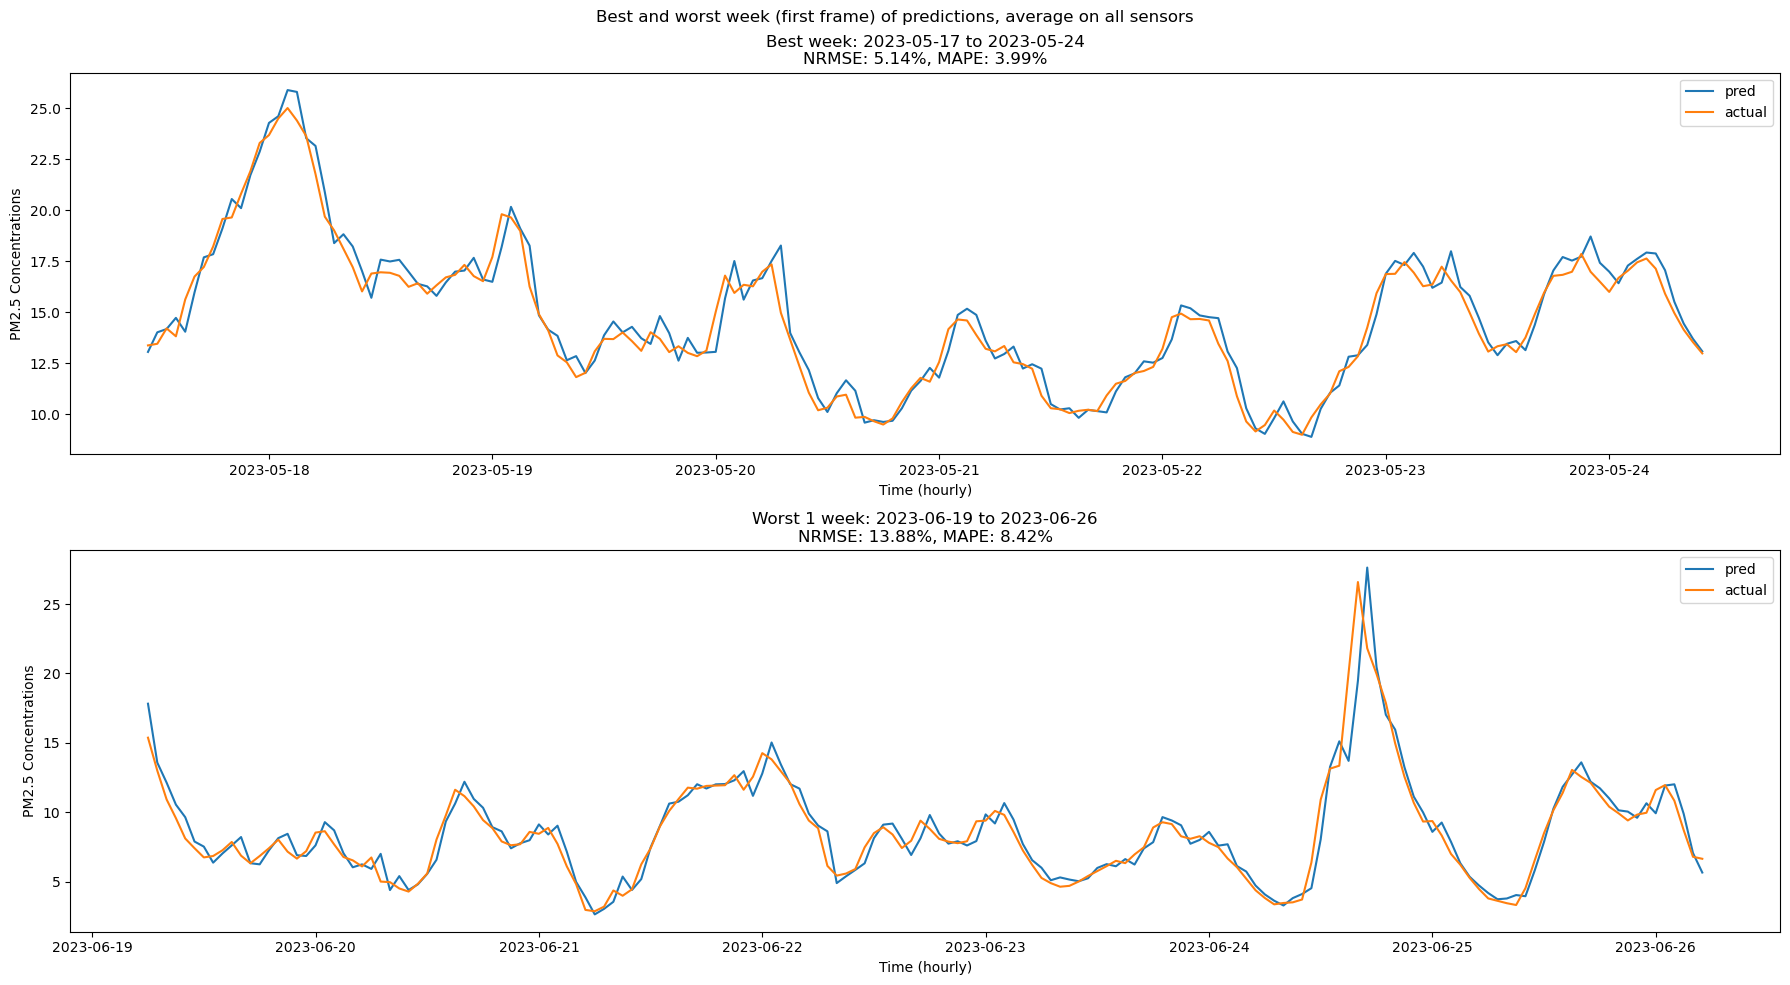

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions, average on all sensors')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    y_pred_avg[best_idx:best_idx+168, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    Y_test_avg[best_idx:best_idx+168, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[best_idx : best_idx + 168]), 
        np.squeeze(y_pred_avg[best_idx : best_idx + 168])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    y_pred_avg[worst_idx:worst_idx+168, 0], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    Y_test_avg[worst_idx:worst_idx+168, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[worst_idx : worst_idx + 168]), 
        np.squeeze(y_pred_avg[worst_idx : worst_idx + 168])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [27]:
# best/worst of an individual sensor
best_week_sensor = float('inf')
worst_week_sensor = float('-inf')
best_sensor, worst_sensor = -1, -1
best_idx_sensor, worst_idx_sensor = 0, 0
for i in range(len(y_pred) - 168):
    for j in range(len(sensor_names)):
        err = nrmse(y_pred[i:i+168, 0, j], Y_test[i:i+168, 0, j])
        if err < best_week_sensor:
            best_week_sensor = err
            best_idx_sensor = i
            best_sensor = j
        if err > worst_week_sensor:
            worst_week_sensor = err
            worst_idx_sensor = i
            worst_sensor = j
print(best_idx_sensor, best_sensor, worst_idx_sensor, worst_sensor)

88 4 788 1


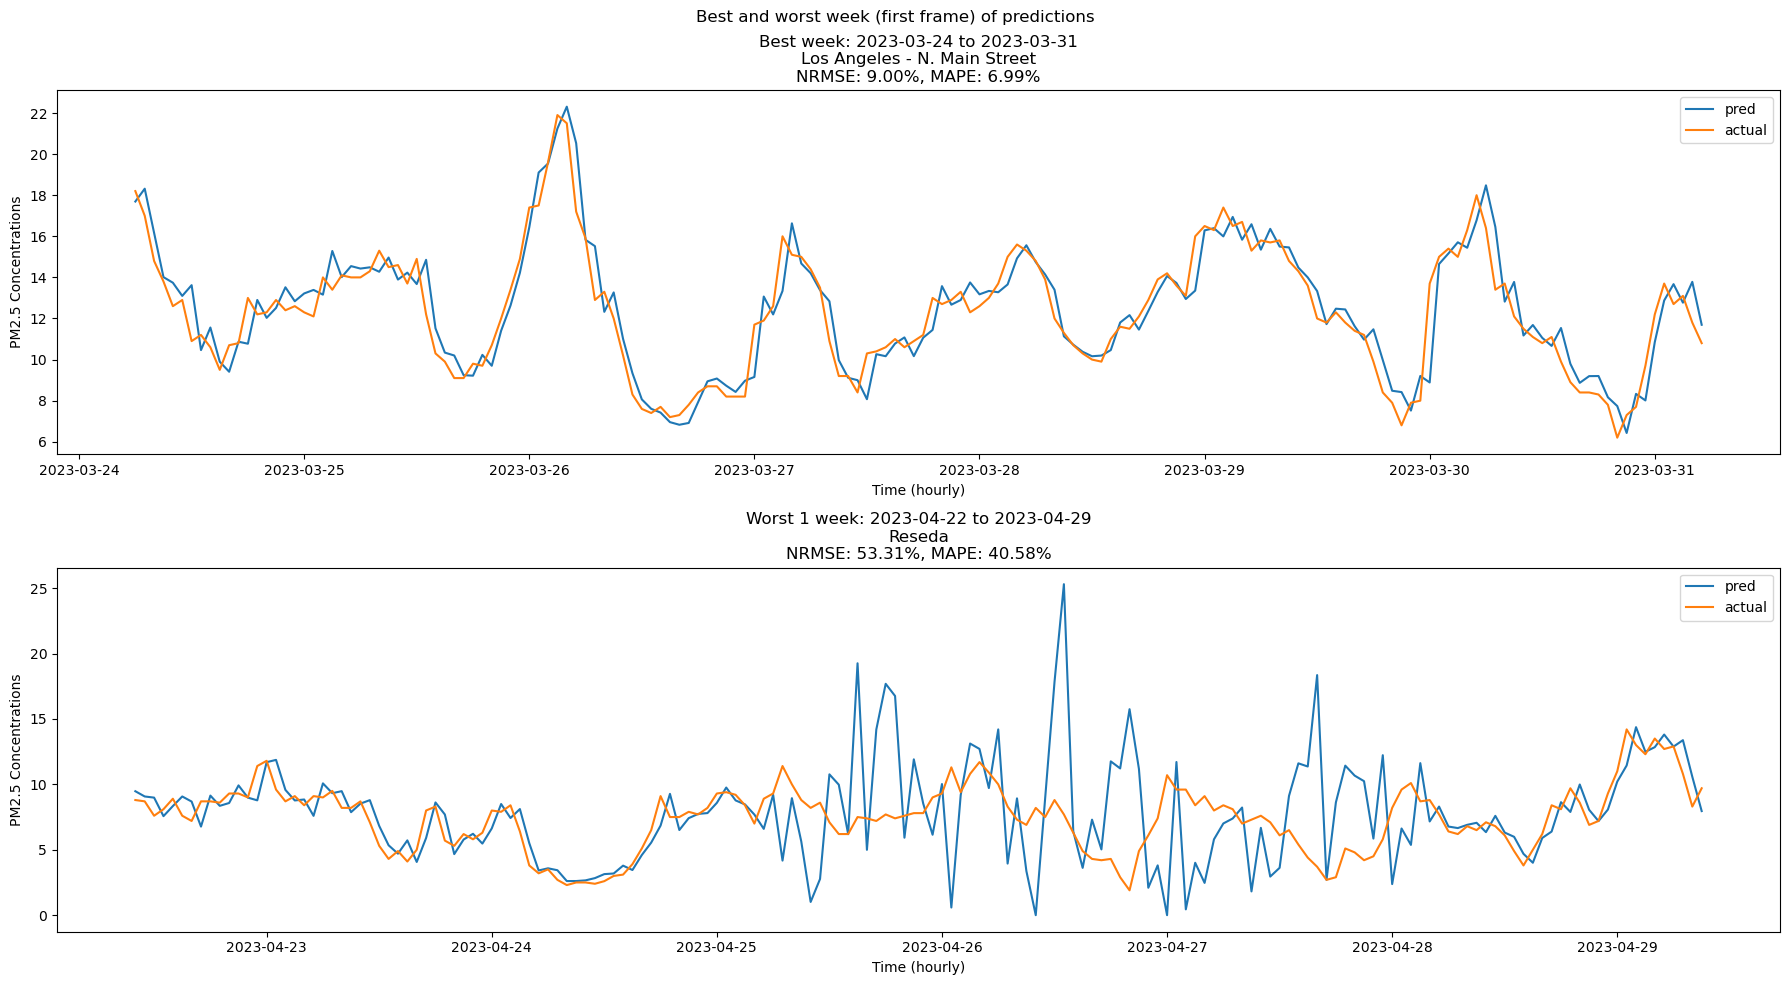

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    y_pred[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    Y_test[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[best_sensor]}\n"
    f"NRMSE: {best_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor]), 
        np.squeeze(y_pred[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    y_pred[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    Y_test[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[worst_sensor]}\n"
    f"NRMSE: {worst_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_sensor : worst_idx_sensor + 168, 0, worst_sensor]), 
        np.squeeze(y_pred[worst_idx_sensor: worst_idx_sensor + 168, 0, worst_sensor])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Rolling avg plots